# Library Imports


In [1]:
# For the creation of models
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


# Data optimization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision

# Moving files into folders
import os
import shutil

# Splitting data
from sklearn.model_selection import train_test_split

# Graphing
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Download the Medical MNIST dataset from personal github
!wget https://github.com/sam-lara/CECS456_Project/raw/main/MedicalMNIST.zip

--2024-12-18 20:51:40--  https://github.com/sam-lara/CECS456_Project/raw/main/MedicalMNIST.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sam-lara/CECS456_Project/main/MedicalMNIST.zip [following]
--2024-12-18 20:51:41--  https://raw.githubusercontent.com/sam-lara/CECS456_Project/main/MedicalMNIST.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88933634 (85M) [application/zip]
Saving to: ‘MedicalMNIST.zip’

MedicalMNIST.zip    100%[===================>]  84.81M   473MB/s    in 0.2s    

2024-12-18 20:51:48 (473 MB/s) - ‘MedicalMNIST.zip’ saved [88933634/88933634]



In [3]:
# unzip files into a new folder - disregard the output via redirection
!unzip MedicalMNIST.zip -d ./MedicalMNST > /dev/null 2>&1

In [4]:
# ensure reproducibility
np.random.seed(42)

# path of folder containing the images
original_dir = './MedicalMNST'

# Create directories for training, validation, and test sets
train_dir = './train'
val_dir = './validation'
test_dir = './test'

# create a list of all classes in the data set
classes = os.listdir(original_dir)

for class_name in classes:
    class_path = os.path.join(original_dir, class_name)

    # make folders for training, validation, and testing sets
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get a list of all images in the current class folder
    all_images = os.listdir(class_path)

    # Split data 80 - 20, for training and testing respectively
    train_images, test_val_images = train_test_split(all_images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

    # Move images to respective directories
    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


In [5]:
# Paths for data set folders
train_dir = "./train"
val_dir = "./validation"
test_dir = "./test"

# Data Generators - only load 128 images at a time to help with memory issues
batch_size = 128

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=batch_size, class_mode="sparse"
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=batch_size, class_mode="sparse"
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=batch_size, class_mode="sparse", shuffle=False
)

Found 47163 images belonging to 6 classes.
Found 5895 images belonging to 6 classes.
Found 5896 images belonging to 6 classes.


In [6]:
# helper function to add residual blocks to the model
def residual_block(x, filters):
    return ReLU()(Add()([
        Conv2D(filters, (3, 3), padding='same')(BatchNormalization()(x)),
        Conv2D(filters, (3, 3), padding='same')(BatchNormalization()(ReLU()(x))),
    ]))

def build_model(input_shape=(150, 150, 3), num_classes=6):
    inputs = Input(shape=input_shape)

    # take care of first layer separately
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    conv1_bn = BatchNormalization()(conv1)
    conv1_relu = ReLU()(conv1_bn)

    # Max Pooling after Convolution
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv1_relu)

    # Residual Blocks and Pooling for Downsampling
    for filters in [64, 128, 256, 512]:
        x = residual_block(x, filters)
        x = MaxPooling2D((2, 2), padding='same')(x)  # Downsampling

    # Global Pooling and Fully Connected Layer
    x = Dense(256, activation='relu')(GlobalAveragePooling2D()(x))

    # Final layer no activation function
    x = Dense(num_classes)(x)

    return Model(inputs, x)

# Build and compile the model
model = build_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 75, 75, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 75, 75, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 75, 75, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 38, 38, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 38, 38, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 38, 38, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 38, 38, 64)     │            256 │ re_lu_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 38, 38, 64)     │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 38, 38, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 19, 19, 64)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 19, 19, 64)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 19, 19, 64)     │            256 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 19, 19, 64)     │            256 │ re_lu_4[0][0]          │
│ (BatchNormalization) 

 Total params: 3,318,918 (12.66 MB)

 Trainable params: 3,316,742 (12.65 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [17]:
# train the model
history = model.fit(
    train_generator,
    epochs=4,
    validation_data=val_generator,
)


Epoch 1/4
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9937 - loss: 0.0427 - val_accuracy: 0.9986 - val_loss: 0.0042
Epoch 2/4
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9989 - loss: 0.0030 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 3/4
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9987 - loss: 0.0057 - val_accuracy: 0.9993 - val_loss: 0.0014
Epoch 4/4
369/369 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9988 - val_loss: 0.0020


In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
predictions = model.predict(test_generator, verbose=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9995 - loss: 0.0011
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step


In [19]:
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Display evaluation results
print(f"Test Accuracy: {100 * test_acc:.4f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Test Accuracy: 99.8813%

Classification Report:
              precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      1000
   BreastMRI       1.00      1.00      1.00       896
         CXR       1.00      1.00      1.00      1000
     ChestCT       1.00      1.00      1.00      1000
        Hand       1.00      0.99      1.00      1000
      HeadCT       1.00      1.00      1.00      1000

    accuracy                           1.00      5896
   macro avg       1.00      1.00      1.00      5896
weighted avg       1.00      1.00      1.00      5896



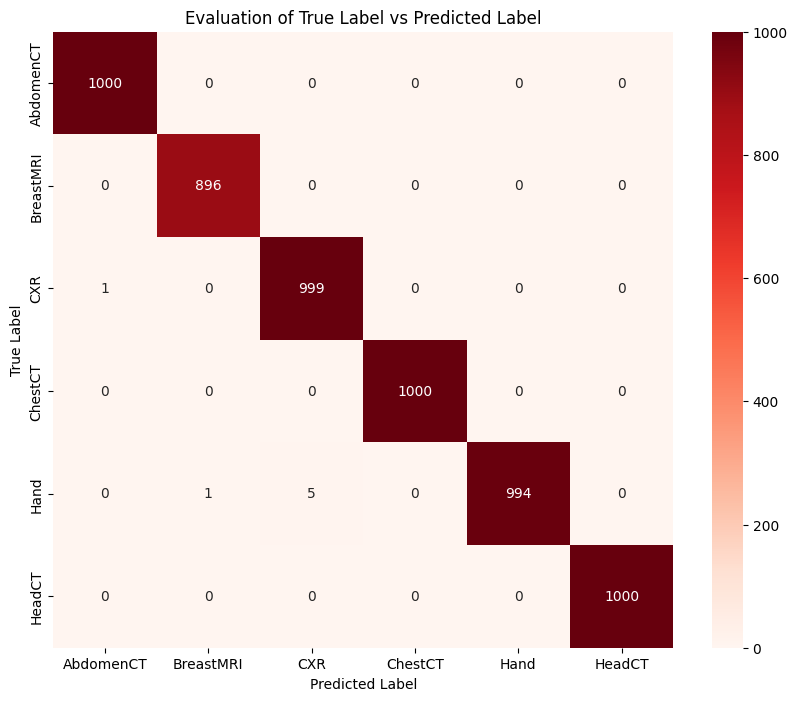

In [20]:
# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Evaluation of True Label vs Predicted Label")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

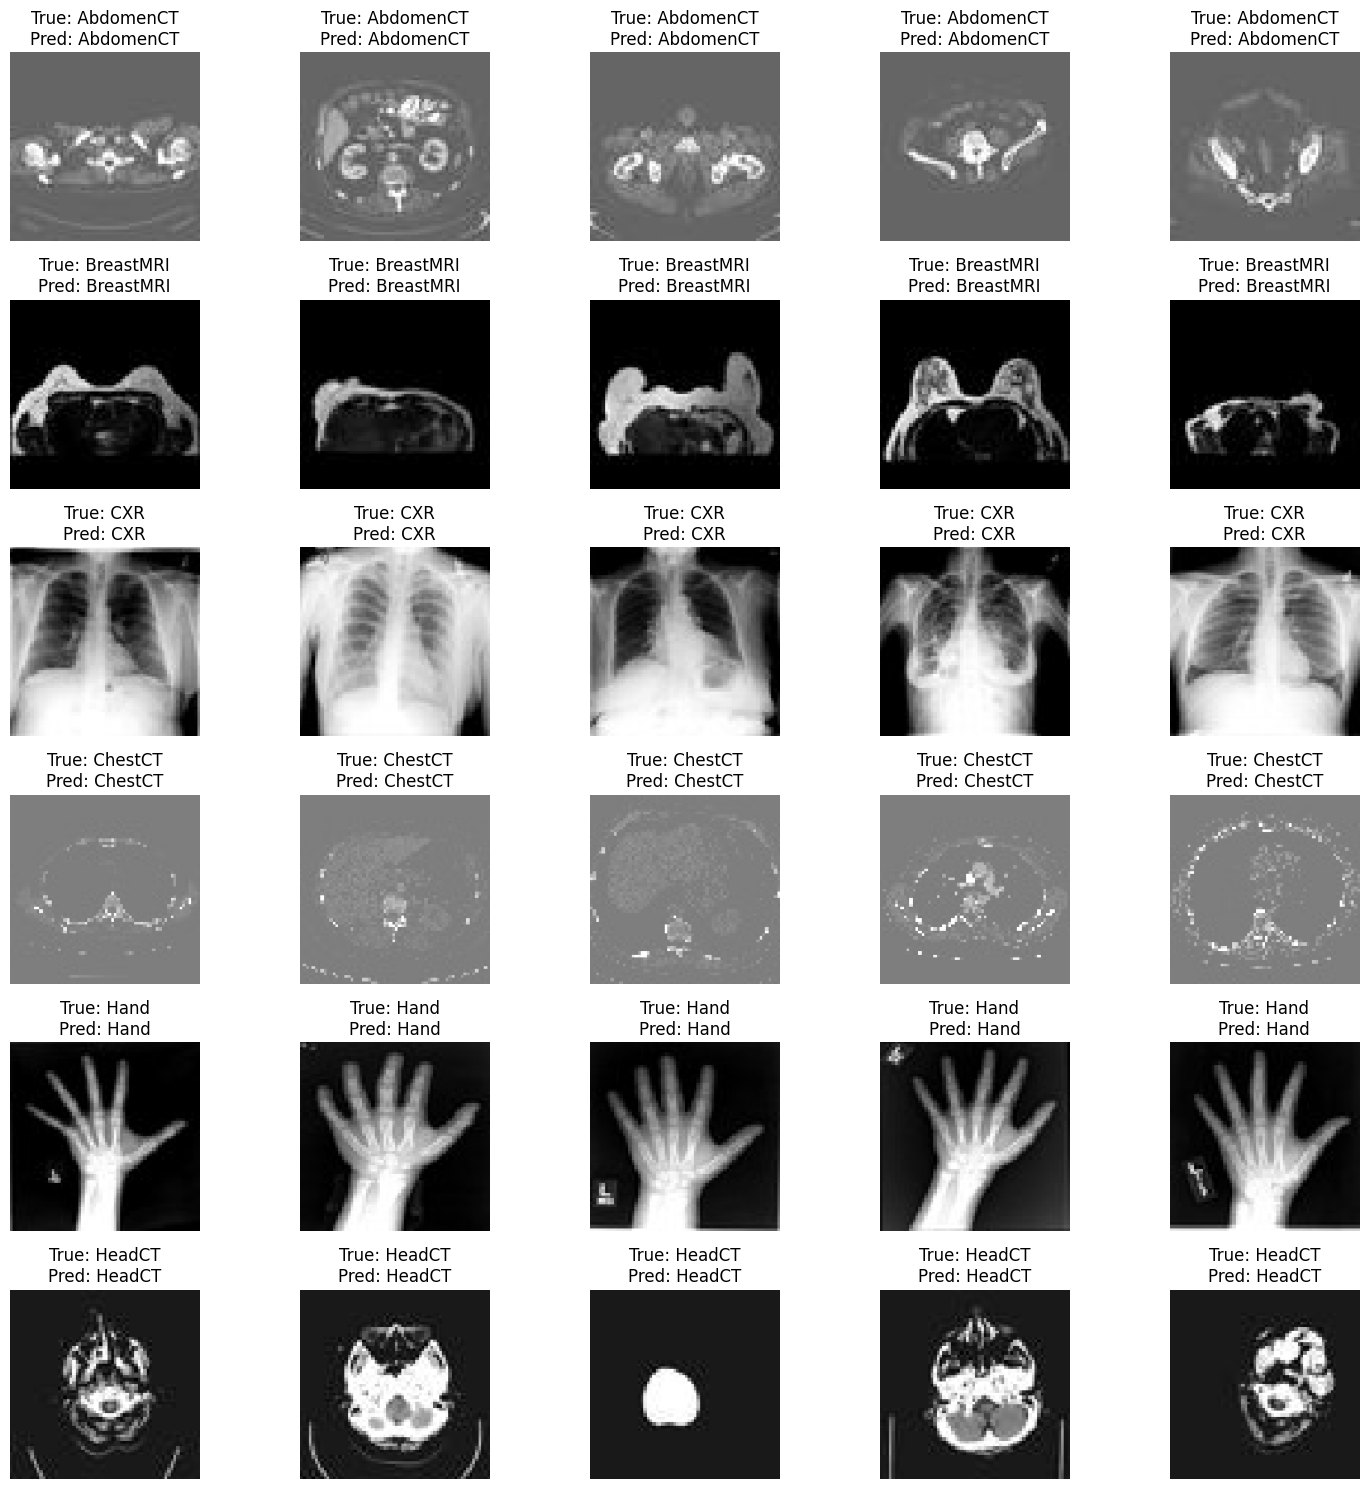

In [27]:
true_labels = test_generator.classes
num_classes = len(class_labels)
fig, axes = plt.subplots(num_classes, 5, figsize=(15, 15))

# Loop through each class
for i in range(num_classes):
    # Find all indices belonging to the current class
    class_indices = np.where(true_labels == i)[0]
    np.random.shuffle(class_indices)

    for j in range(5):
        idx = class_indices[j]

        # Determine which batch the image belongs to
        batch_idx = idx // test_generator.batch_size
        within_batch_idx = idx % test_generator.batch_size

        # Access the specific batch
        batch_images, batch_labels = test_generator[batch_idx]

        # Denormalize the image
        img = batch_images[within_batch_idx]
        img = img * 255 if img.max() <= 1 else img
        img = img.astype("uint8")

        # Get the true and predicted labels
        true_label = class_labels[true_labels[idx]]
        predicted_label = class_labels[np.argmax(predictions[idx])]

        # Plot the image
        ax = axes[i, j]
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
        ax.axis("off")

plt.tight_layout()
plt.show()
